In [1]:
#!pyspark --version
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/03/11 17:05:33 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import VectorAssembler

In [3]:
data = spark.read.csv("preprocessed_PCA.csv", header=True, inferSchema=True)
# Prepare data for training
assembler = VectorAssembler(inputCols=["PC1", "PC2","PC3","PC4", "PC5","PC6","PC7", "PC8","PC9","PC11", "PC11","PC12","PC13","PC14", "PC15","PC16","PC17", "PC18","PC19","PC20","PC21","Amount"], outputCol="features")
data = assembler.transform(data).select("Class", "features")
data.show(5)
data1=data.withColumnRenamed("Class","label")
data1.show(2)

23/03/11 17:05:43 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
+-----+--------------------+
|Class|            features|
+-----+--------------------+
|    0|[-1.093789312,1.7...|
|    0|[-0.435343534,0.2...|
|    0|[-0.156984757,-0....|
|    0|[0.860355689,1.00...|
|    1|[-0.981323376,-1....|
+-----+--------------------+
only showing top 5 rows

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    0|[-1.093789312,1.7...|
|    0|[-0.435343534,0.2...|
+-----+--------------------+
only showing top 2 rows



In [4]:
(trainingData, testData) = data1.randomSplit([0.7, 0.3])

# Train a logistic regression model
lr = LogisticRegression(maxIter=100, regParam=0.3, elasticNetParam=0.8)


import time
import datetime

# start time
start_time = time.time()
datetime_obj1 = datetime.datetime.fromtimestamp(start_time)
print(f"Start time: {datetime_obj1}")

 
    
lrModel = lr.fit(trainingData)
# end time
end_time = time.time()
datetime_obj2 = datetime.datetime.fromtimestamp(end_time)

# calculate the difference between start and end times in seconds
duration = end_time - start_time

# display the results
print(f"End time: {datetime_obj2}")
print(f"Duration: {duration} seconds")


Start time: 2023-03-11 17:05:44.913837


23/03/11 17:05:48 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/03/11 17:05:48 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
End time: 2023-03-11 17:05:50.555790
Duration: 5.641952753067017 seconds


In [5]:

# Make predictions on test data
predictions_lg = lrModel.transform(testData)


In [6]:

# Evaluate the model
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
areaUnderROC = evaluator.evaluate(predictions_lg)
print("Accuracy LogisticRegression= {}".format(areaUnderROC))

Accuracy LogisticRegression= 0.8988023379122934


In [7]:
# Create a confusion matrix
from pyspark.sql.functions import col

confusion_matrix_lg = predictions_lg.groupBy("label", "prediction") \
    .count() \
    .orderBy(["label", "prediction"]) \
    .select("label", "prediction", col("count").alias("frequency"))

# Display the confusion matrix
confusion_matrix_lg.show()

+-----+----------+---------+
|label|prediction|frequency|
+-----+----------+---------+
|    0|       0.0|    23487|
|    1|       0.0|    10146|
+-----+----------+---------+



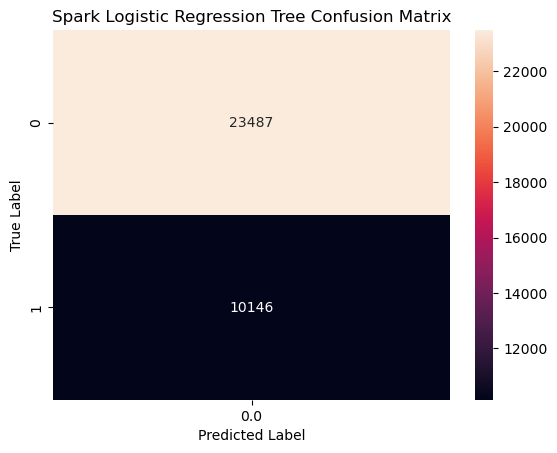

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
# Convert the confusion matrix to a Pandas DataFrame
pandas_df = confusion_matrix_lg.toPandas()

# Create a pivot table to reshape the data for plotting
pivot = pandas_df.pivot(index="label", columns="prediction", values="frequency")

# Create a heatmap plot of the confusion matrix
sns.heatmap(pivot, annot=True, fmt="d")

# Set the plot title and axis labels
plt.title("Spark Logistic Regression Tree Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Show the plot
plt.show()

In [9]:
# Compute the precision for class 0
tp = predictions_lg.filter("label = 0 and prediction = 0").count()
fp = predictions_lg.filter("label = 1 and prediction = 0").count()
precision_0 = tp / (tp + fp)
print("Precision for class 0 = %g" % precision_0)

# Compute the precision for class 1
tp = predictions_lg.filter("label = 1 and prediction = 1").count()
fp = predictions_lg.filter("label = 0 and prediction = 1").count()
precision_1 = tp / (tp + fp)
print("Precision for class 1 = %g" % precision_1)

Precision for class 0 = 0.698332


ZeroDivisionError: division by zero